<a href="https://colab.research.google.com/github/michelucci/aadl2-code/blob/master/chapter5/Pattern_Neural_style_transfer_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural style transfer

This code has been heavily taken from the tensorflow.org website and slightly updated to make it easier for the readers to follow with more comments and documentations. This notebook can be used freely for any purposes and the copyright remains mainly with the tensofrlow team. 

Contact: Umberto Michelucci

www.toelt.ai

umberto.michelucci@toelt.ai


## Setup


### Import and configure modules

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
import functools

Download images and choose a style image and a content image:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/My Drive/data"

darth.jpg  landscape.jpg  mosaic.jpg  _OLD  vangogh.jpg  vangogh_landscape.jpg


In [0]:
content_path = '/content/drive/My Drive/data/darth.jpg'
style_path = '/content/drive/My Drive/data/glass.jpg'
output_path = '/content/drive/My Drive/data/output.jpg'

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

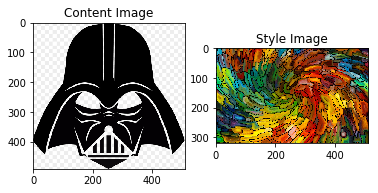

In [196]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Choose intermediate layers from the network to represent the style and content of the image:


In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [0]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [0]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [0]:
extractor = StyleContentModel(style_layers, content_layers)

## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [0]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [0]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [0]:
style_weight=1
content_weight=1e4

In [0]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image. Note that when you annotate a function with tf.function, you can still call it like any other function. But it will be compiled into a graph, which means you get the benefits of faster execution, running on GPU or TPU, or exporting to SavedModel (see https://www.tensorflow.org/alpha/guide/autograph).

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

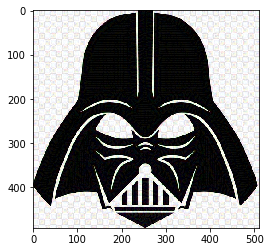

In [210]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

Since it's working, perform a longer optimization:

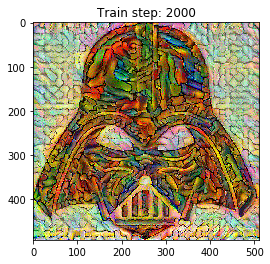

Total time: 209.6


In [211]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Let's clip the image

In [0]:
result = np.array(image.read_value()[0])
mask = load_img(content_path)[0]
mask = np.array(mask*255, dtype = np.int)

In [0]:
mask[mask > 230] = 255
mask[mask < 50] = 0
mask2 = mask == 255

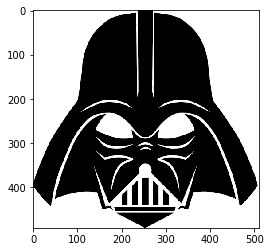

In [214]:
imshow(mask)

In [0]:
result[mask2] = 255

W0508 20:50:07.826817 140458938664832 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


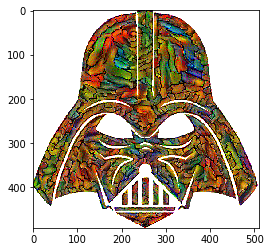

In [216]:
imshow(result)

## Comparison with basic clipping

In [128]:
mask.shape

(492, 512, 3)

In [0]:
mosaic = Image.open(style_path)
width = 512
height = 492
mosaic2 = np.array(mosaic.resize((width, height), Image.NEAREST))

In [139]:
type(mosaic2)

numpy.ndarray

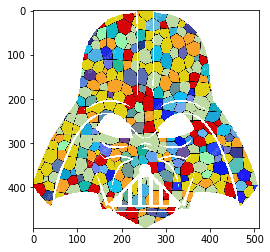

In [140]:
mosaic2[mask2] = 255
imshow(mosaic2)

# Save the image

In [217]:
from PIL import Image

import matplotlib
file_name = 'output.png'
matplotlib.image.imsave(file_name, result)

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(file_name)

W0508 20:50:19.358954 140458938664832 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [0]:
from PIL import Image

import matplotlib
file_name = 'cypress_output.png'
matplotlib.image.imsave(file_name, image[0])

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(file_name)